Can we train a linear debiasing model on top of the neural network that improves the Q2 prediction from a model traind with multiple time steps?

In [1]:
import torch
from uwnet.columns import single_column_simulation
from uwnet.thermo import compute_apparent_source
from uwnet.pre_post import prepare_data

In [2]:
ds = xr.open_dataset("../data/processed/training.nc").isel(time=slice(0, 200), step=0)
model = torch.load("../models/268/5.pkl")

output = model.call_with_xr(ds)

dt = .125 * 86400

q1 = compute_apparent_source(ds.SLI, ds.FSLI*86400)
q2 = compute_apparent_source(ds.QT, ds.FQT*86400)
ds['Q2'] = q2

ds['FQTNN'] = output['QT']

ds = ds.dropna('time')

# Bias

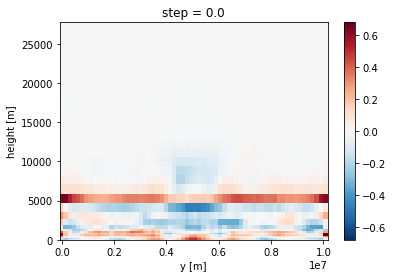

In [3]:
dims = ['time', 'x']
bias = output.QT.mean(dims)-q2.mean(dims)
bias.plot(x='y')

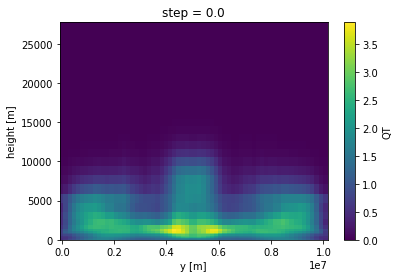

In [4]:
output.QT.std(dims).plot(x='y')

There is large bias near z=5000. This is the final humidity level used in the NN.

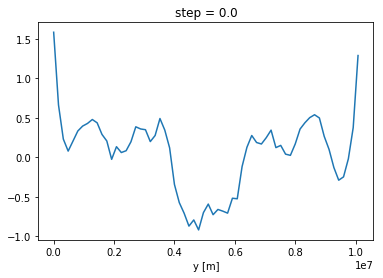

In [5]:
bias_net = (bias*ds.layer_mass).sum('z')/1000
bias_net.plot()

This is a 1mm/day bias in the tropical humidity.

## Percent bias

In [6]:
percent_bias = output.QT.mean(dims)/q2.mean(dims) - 1

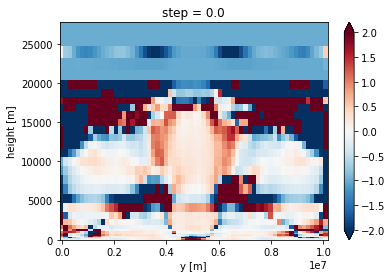

In [7]:
percent_bias.plot(vmax=2)

# For each height/lat fit a new linear model

$  A_{jk} q[:, j, k] + b_{jk} $

In [8]:
from sklearn.linear_model import Lasso

In [9]:
# input vars
input_vars = ['QT', 'FQTNN']
output_var = 'Q2'
all_vars = input_vars + [output_var]


def fit_linear(dfjk):    
    df = dfjk.to_dataframe().reset_index()
    x_train = df[input_vars]
    y_train = df[output_var]

    debiaser = Lasso(alpha=.0001, normalize=True).fit(x_train, y_train)
    params = np.append(debiaser.coef_, debiaser.intercept_)
    return xr.DataArray(params)

In [10]:
groupby = ds.stack(g=['y', 'z']).groupby('g')
params = groupby.apply(fit_linear)

params = params.unstack('g')

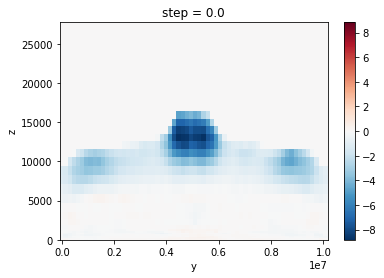

In [11]:
params[0].plot(x='y')

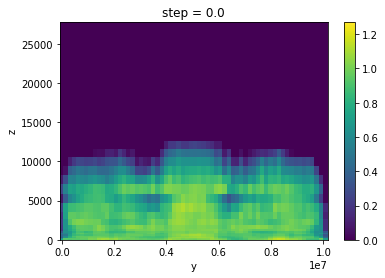

In [12]:
params[1].plot(x='y')

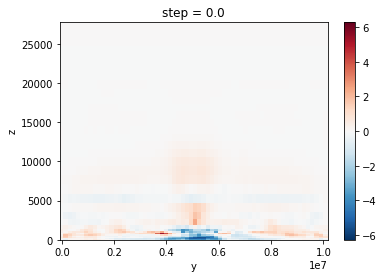

In [13]:
params[2].plot(x='y')

In [14]:
debiased_fqtnn = ds.QT * params[0] + params[1] * ds.FQTNN + params[2]

In [15]:
o =  ds.QT * params[0]

In [16]:
bias = debiased_fqtnn.mean(['x', 'time']) - q2.mean(['x', 'time'])

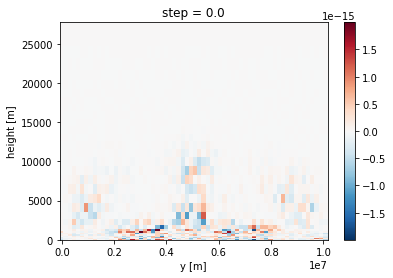

In [17]:
bias.plot()

The bias is identically zero! The Lasso fit must be enforcing that explicitly somewhere.